In [1]:
# Import relevant libraries and packages

# Import visualization libraries and pandas/numpy to manipulate our data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For logistic regression modeling steps
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, PolynomialFeatures
from sklearn.linear_model import LogisticRegression

# Libraries for classification metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    recall_score, log_loss, classification_report

We will be using a dataset from UCI's Machine Learning Repository that tracked survival rates of patients who underwent an operation for breast cancer at the University of Chicago's Billings Hospital between 1958 and 1970. The dataset includes the age at the time of the operation, the year of the operation (year - 1900), the number of positive axillary nodes (lymph node in the armpit area in which cancer has spread), and whether or not the patient lived more than 5 years post operation. 

In [2]:
# Load in our dataset and inspect. We need to add column names for the dataset as well

colnames = ['age_during_op', 'year_of_op', 'pos_ax_nodes', 'death_5yr']

df = pd.read_csv('./data/haberman.csv', names=colnames, header=None)
df.head()

,age_during_op,year_of_op,pos_ax_nodes,death_5yr
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


In [3]:
# Inspect column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age_during_op  306 non-null    int64
 1   year_of_op     306 non-null    int64
 2   pos_ax_nodes   306 non-null    int64
 3   death_5yr      306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


In [4]:
# The dataset uses 1's and 2's for the death_5yr column. 
# We want to convert these to 0's (survived more than 5 years) and 1's (passed within 5 years of the operation)

df['death_5yr'].value_counts()


1    225
2     81
Name: death_5yr, dtype: int64

In [5]:
df['death_5yr'] = df['death_5yr'].map({1:0, 2:1})

In [6]:
df['death_5yr'].value_counts()

0    225
1     81
Name: death_5yr, dtype: int64

Now that we have our data structured how we like, we can move forward with logistic regression.

In [7]:
# First, we'll create our test_train split to ensure no data leakage occurs in our model
X = df.drop('death_5yr', axis=1)
y = df['death_5yr']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# confirm that our test size is one quarter of the training size
print(X_train.shape, X_test.shape)

(244, 3) (62, 3)


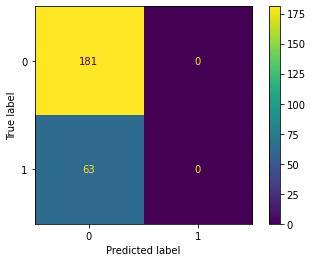

In [9]:
# Create a dummy model that always predicts the majority class (survived more than 5 years)
# This is our baseline model

# Instantiate the model
dummy_model = DummyClassifier(strategy='most_frequent')

# Fit our model to our training data
dummy_model.fit(X_train, y_train)

# View the confusion matrix
plot_confusion_matrix(estimator=dummy_model, X=X_train, y_true=y_train);

# save the plot as an image
plt.savefig('dummy_model.png', dpi=400)

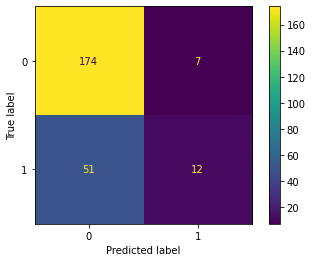

In [10]:
# Now that we have a baseline model, we can create our first logistic regression model

# Instantiate the model
log_model = LogisticRegression(random_state=42)

# Fit the model to our training data
log_model.fit(X_train, y_train)

# View the confusion matrix for our first logistic regression model
plot_confusion_matrix(estimator=log_model, X=X_train, y_true=y_train);


This model appears to perform slightly better than the dummy model. However, we forgot one key step: normalize the input variables. Without normalizing our variables, variables that are magnitudes greater than others will be penalized more. We will use the normalize method to scale our X data. 

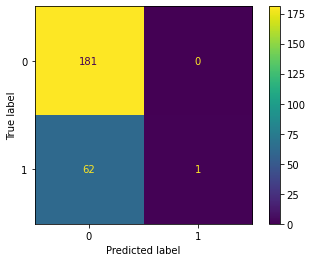

In [11]:
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

# Fit the model to our normalized training data
log_model.fit(X_train_norm, y_train)

# View the confusion matrix 
plot_confusion_matrix(estimator=log_model, X=X_train_norm, y_true=y_train);

plt.savefig('log_norm.png', dpi=400)

In [12]:
log_model.score(X_train_norm, y_train)

0.7459016393442623

In [13]:
recall_score(y_train, log_model.predict(X_train_norm))

0.015873015873015872

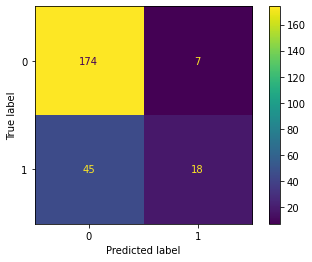

In [14]:
# Instantiate the model
log_model = LogisticRegression(C=10000, solver='liblinear', random_state=42)

# Fit the model to our training data
log_model.fit(X_train_norm, y_train)

# View the confusion matrix for our first logistic regression model
plot_confusion_matrix(estimator=log_model, X=X_train_norm, y_true=y_train);

plt.savefig('log_norm_hyp_param.png', dpi=400)

In [15]:
log_model.score(X_train_norm, y_train)

0.7868852459016393

In [16]:
recall_score(y_train, log_model.predict(X_train_norm))

0.2857142857142857

In [17]:
# Given that we only have 3 columns to predict our target, we will use the Polynomial Features class from 
# sklearn to increase the number of input features

# Instantiate transformer
pf = PolynomialFeatures(degree=3)

# Fit the transformer to our training X data. Transform both training and testing sets
pf.fit(X_train)
X_train_poly = pf.transform(X_train)
X_test_poly = pf.transform(X_test)

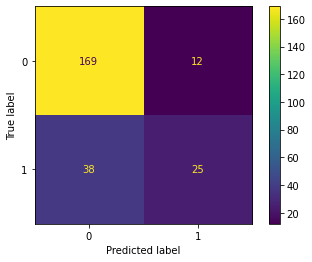

In [18]:
# instantiate the model
log_poly_model = LogisticRegression(C=10000, solver='liblinear', random_state=42, max_iter=10000)

# fit the model
log_poly_model.fit(X_train_poly, y_train)

# view confusion matrix
plot_confusion_matrix(log_poly_model, X_train_poly, y_train);

plt.savefig('log_reg_poly.png', dpi=400)

In [19]:
log_poly_model.score(X_train_poly, y_train)

0.7950819672131147

In [20]:
recall_score(y_train, log_poly_model.predict(X_train_poly))

0.3968253968253968

In [21]:
classification_report(y_train, log_poly_model.predict(X_train_poly))

'              precision    recall  f1-score   support\n\n           0       0.82      0.93      0.87       181\n           1       0.68      0.40      0.50        63\n\n    accuracy                           0.80       244\n   macro avg       0.75      0.67      0.69       244\nweighted avg       0.78      0.80      0.78       244\n'

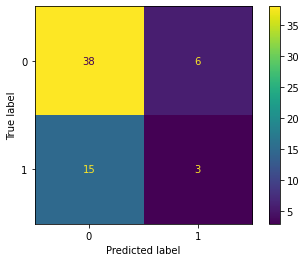

In [21]:
# Given that this is our best model so far, we can run the model on our testing data set
plot_confusion_matrix(log_poly_model, X_test_poly, y_test);

plt.savefig('log_reg_poly_test.png', dpi=400)

In [22]:
log_poly_model.score(X_test_poly, y_test)

0.6612903225806451

In [23]:
recall_score(y_test, log_poly_model.predict(X_test_poly))

0.16666666666666666